In this project I will be trying to predict future weather patterns given historical weather trends in London England.

The data set can be found on kaggle at https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer

In [5]:
df = pd.read_csv("london_weather.csv")
print(df.info(), end = "\n")
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB
None


,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [6]:
#checking for missing data and replacing with 0.0
df.isna().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [7]:
#replacing missing data with mean
df = df.fillna(value = df.mean())

In [8]:
#fixing date for formatting reasons

#creating function as default formatting does not return good
def date_format(x):
    temp = str(x)
    x = str(temp[:4] + "-" + temp[4:6] + "-" + temp[6:])
    return x
    
df["date"] = df["date"].apply(date_format)
df["date"] = pd.to_datetime(df["date"])

df["year"] = pd.to_datetime(df["date"]).dt.year
df["month"] = pd.to_datetime(df["date"]).dt.month
df["day"] = pd.to_datetime(df["date"]).dt.day

df.insert(1, 'year', df.pop("year"))
df.insert(2, 'month', df.pop("month"))
df.insert(3, 'day', df.pop("day"))

df = df.drop(columns = "date")

df.head()

,year,month,day,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,1979,1,1,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,1979,1,2,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,1979,1,3,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,1979,1,4,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,1979,1,5,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


<Axes: >

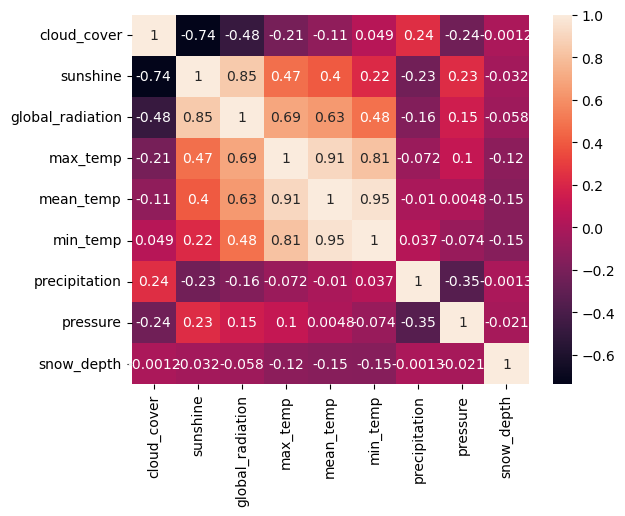

In [9]:
df_nodate = df.drop(columns = ["year","month","day"])
sns.heatmap(df_nodate.corr(), annot=True)

Initial interpretation and viewing of our data. Tbis can show major outliers in the data or patterns that we can try to follow in future analysis and prediction

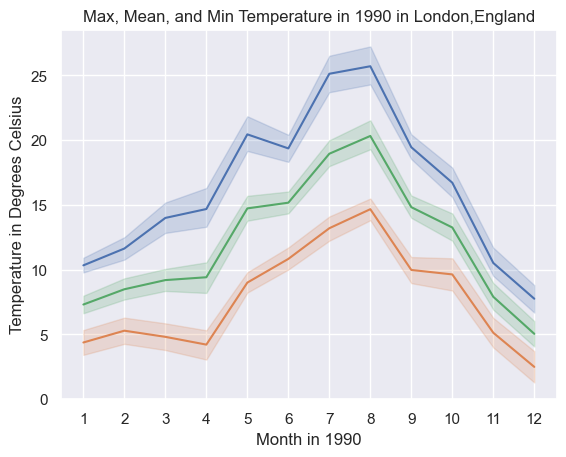

In [10]:
#graphing max,mean,and min temp for a given year
def temp_plot_year(year_of_interest):
    sns.set_theme(style = "darkgrid")

    sns.lineplot(data = df[df["year"] == year_of_interest], x = "month", y = "max_temp")
    sns.lineplot(data = df[df["year"] == year_of_interest], x = "month", y = "min_temp")
    sns.lineplot(data = df[df["year"] == year_of_interest], x = "month", y = "mean_temp")

    plt.xlabel(f"Month in {year_of_interest}")
    plt.ylabel(f"Temperature in Degrees Celsius")
    plt.title(f"Max, Mean, and Min Temperature in {year_of_interest} in London,England")
    plt.xticks(range(1, 13))
    plt.show()

temp_plot_year(1990)

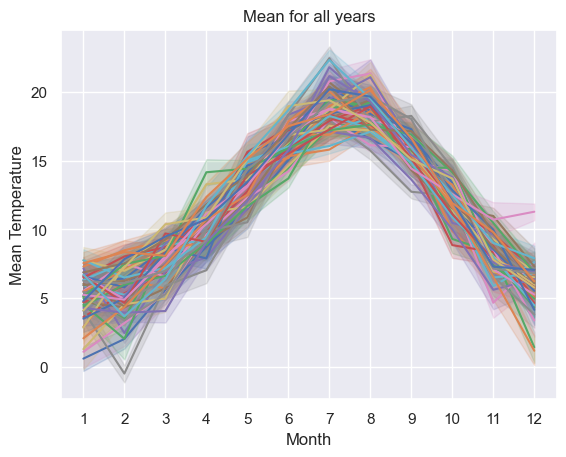

In [11]:
#plotting all average temperatures for all year
year_list = df["year"].unique()

for year in year_list:
    sns.lineplot(data = df[df["year"] == year], x = "month", y = "mean_temp")

plt.xlabel(f"Month")
plt.ylabel(f"Mean Temperature")
plt.title(f"Mean for all years")
plt.xticks(range(1, 13))

plt.show()

In [12]:
#getting the average temperature for each year, and checking for an increase
df_year_avg = df.groupby(df['year']).mean()
df_year_avg = df_year_avg[["max_temp","mean_temp","min_temp"]]
df_year_avg.head()

,max_temp,mean_temp,min_temp
year,,,
1979,13.759178,9.986575,6.217808
1980,14.176230,10.370492,6.587978
1981,14.063562,10.320000,6.574795
1982,15.004658,10.998904,7.006301
1983,15.248767,11.237260,7.227397


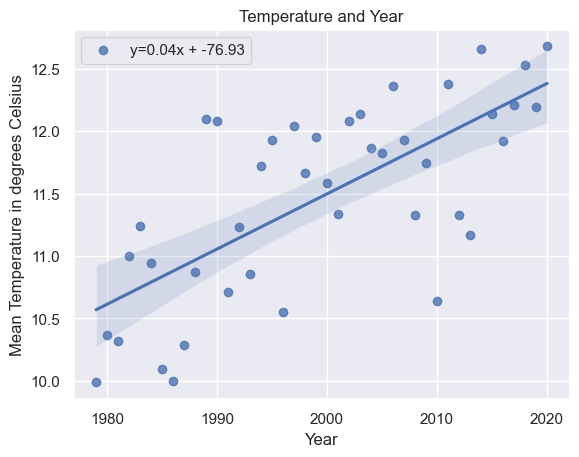

In [13]:
#plotting the line with line of best fit
slope, intercept, r_value, p_value, std_err = stats.linregress(df_year_avg.index, df_year_avg["mean_temp"])

sns.set_theme(style = "darkgrid")

sns.regplot(data = df_year_avg, 
            x = df_year_avg.index, 
            y = "mean_temp",
            label = f'y={slope:.2f}x + {intercept:.2f}')

plt.title('Temperature and Year')
plt.xlabel('Year')
plt.ylabel('Mean Temperature in degrees Celsius')
plt.legend()
plt.show()

Adding collumns here for better predictions. Weather is fairly consistent across similar days, week, and month, so I will add average for the week using rolling averages. Periods were picked for previous 2 days, week, month, 3 month, and year

In [14]:
border = [2,7,30,90,365]
border_predictors = []

for border in border:
    df[f"rolling_{border}_mean"] = df["mean_temp"].rolling(window = border).mean().shift(1)
    df[f"rolling_{border}_std"] = df["mean_temp"].rolling(window = border).std().shift(1)

    border_predictors.append(f"rolling_{border}_mean")
    border_predictors.append(f"rolling_{border}_std")

Since months are cyclical, attempting to use sin and cos to present to the model better

In [15]:
df["month_sin"] = np.sin(2 * np.pi *df["month"]/12)
df["month_cos"] = np.cos(2 * np.pi *df["month"]/12)

***Random Forest Regressor***

Beginning of prediction of average temperature based on other factors. First we have to set up a random forest and get the predictors, then split into testing and training. This is a time series data set, so we will use the last 400 days (a bit over a year) for validation, while the rest will be used for training.

In [ ]:
model = RandomForestRegressor(n_estimators = 200,
                               min_samples_split = 50,
                               random_state = 1)

#all columns except for any related to temperature
predictors = ["year",
              "month",
              "day",
              "cloud_cover", 
              "sunshine",
              "global_radiation", 
              "precipitation", 
              "pressure",
              "snow_depth",
              "month_sin",
              "month_cos"]

predictors = predictors + border_predictors

train = df.iloc[:-400]
X_train = train[predictors]
Y_train = train["mean_temp"]

test = df.iloc[-400:]
X_test = test[predictors]
Y_test = test["mean_temp"]

model.fit(X_train,Y_train)


RandomForestRegressor(min_samples_split=50, n_estimators=200, random_state=1)

After the model has been trained to predict mean_temp based on a variety of predictors, we now need to verify how good the regressor is. 

In [17]:
Y_pred = model.predict(X_test)
Y_pred = pd.Series(Y_pred, index = Y_test.index)

In [18]:
features = pd.DataFrame(model.feature_importances_,index = predictors)
features = features.rename(columns = {0:"Importance"})
features = features.sort_values(by = "Importance", ascending = False)
features.head()

,Importance
rolling_2_mean,0.931438
cloud_cover,0.009709
global_radiation,0.008871
rolling_30_mean,0.006369
rolling_2_std,0.005211


In [19]:
mse = mean_squared_error(Y_test,Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_test,Y_pred)
r2 = r2_score(Y_test,Y_pred)

print(f"MSE : {mse}")
print(f"RMSE : {rmse}")
print(f"MAE : {mae}")
print(f"R2 : {r2}")

MSE : 6.4456586176276485
RMSE : 2.53883016714936
MAE : 1.9351788677825845
R2 : 0.7855111141473561


Since both our MSE and RMSE are fairly low, it shows that our prediction matches the actual results well. 
With an MAE of 1.5477 degrees celsius, we show that our model is accurate. On average, our predicted temperature varies from the actual temperature by about 1.5477 degrees.
88.18 percent of the variation observed in the predicted y values is explained by variation in the actual y values. While the R square value is high, it is not so high that it indicates overfitting.

Creating graphs for interpretation, making sure there are no major outliers or signs that the relationship is unclear or off in some way

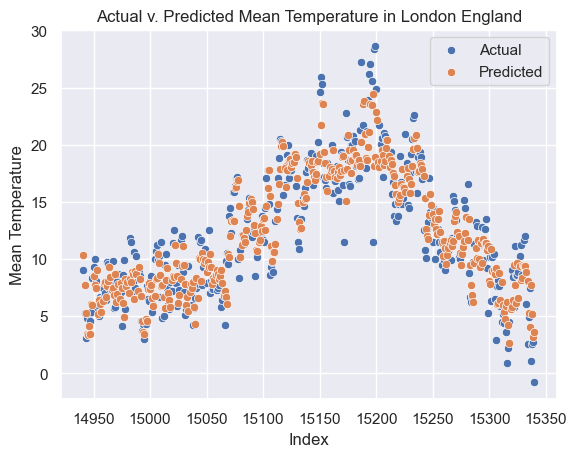

In [20]:
sns.set_theme(style = "darkgrid")

sns.scatterplot(x = Y_test.index, y = Y_test.values, label = "Actual")
sns.scatterplot(x = Y_pred.index, y = Y_pred.values, label = "Predicted")

plt.xlabel(f"Index")
plt.ylabel(f"Mean Temperature")
plt.title(f"Actual v. Predicted Mean Temperature in London England")

plt.show()

Predicted values closely follow the shape of the actual values. Although some outliers are detected around midway through the year, this is likely due to the 2021 British Isles heatwave, which was a large spike in heat during mid to late July.

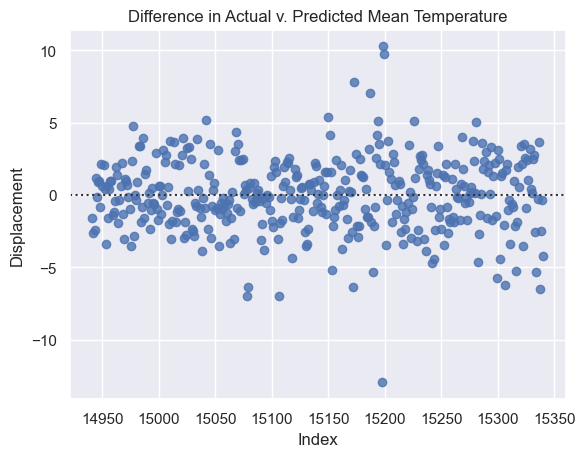

In [21]:
#residual graph
residuals = pd.DataFrame(Y_test)
residuals["predicted mean_temp"] = Y_pred
residuals["diff"] = residuals["mean_temp"] - residuals["predicted mean_temp"]
residuals.head()

sns.set_theme(style = "darkgrid")
sns.residplot(x = residuals.index, y = residuals["diff"])

plt.xlabel(f"Index")
plt.ylabel(f"Displacement")
plt.title(f"Difference in Actual v. Predicted Mean Temperature")

plt.show()

Our residuals are evenly distributed, except for the large residuals around the 2021 British Isles heatwave.